In [16]:
from phimal_utilities.data import Dataset_2D
from phimal_utilities.data.diffusion import AdvectionDiffusionGaussian2D

import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dataset = Dataset_2D(AdvectionDiffusionGaussian2D, D=2.0, x0=[0.0, 0.0], sigma=0.5, v=[0.1, 0.1])

In [3]:
# Making grid
x = np.linspace(-10, 10, 100)
t = np.linspace(0.0, 1.0, 25)
x_grid, y_grid, t_grid = np.meshgrid(x, x, t, indexing='ij')

X = np.concatenate([x_grid.reshape(-1, 1), y_grid.reshape(-1, 1)], axis=1)

In [4]:
u = dataset.generate_solution(X, t_grid.reshape(-1, 1))

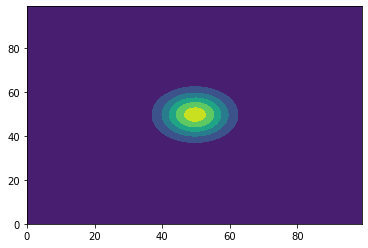

In [5]:
frame = 10
plt.contourf(u.reshape(x_grid.shape)[:, :, frame])

In [6]:
t_deriv=dataset.time_deriv(X,t_grid.reshape(-1,1)).reshape(x_grid.shape)

In [12]:
library_deriv = dataset.library(X, t_grid.reshape(-1,1))

In [13]:
x_grid.shape

(100, 100, 25)

In [14]:
t_deriv.shape

(100, 100, 25)

In [15]:
plt.contourf(library_deriv[:,:,2,2])


IndexError: too many indices for array

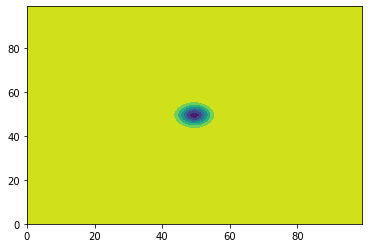

In [36]:
plt.contourf(t_deriv[:,:,3])


In [90]:
config = {'n_in': 3, 'hidden_dims': [30, 30, 30, 30, 30], 'n_out': 1, 'library_function':library_2Din_1Dout, 'library_args':{'poly_order':2, 'diff_order': 3}}
n_runs = 5

In [91]:
dataset = Dataset_2D(AdvectionDiffusionGaussian2D, D=2.0, x0=[0.0, 0.0], sigma=0.5, v=[0.1, 0.1])

In [92]:
x_grid.shape

(100, 100, 25)

In [94]:
 X_train, y_train, rand_idx = dataset.create_dataset(X,t_grid.reshape(-1,1), n_samples=1000, noise=0.1, random=True, return_idx=True)

In [95]:
X_train.shape

torch.Size([1000, 3])

In [96]:
theta = dataset.library(X,t_grid.reshape(-1,1))[rand_idx, :]
dt = dataset.time_deriv(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1))[rand_idx, :]

In [97]:
model = DeepMod(**config)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True)

In [81]:
X_train.shape

torch.Size([1000, 3])

In [82]:
train(model, X_train, y_train, optimizer, 20000, loss_func_args={'library':torch.tensor(theta) ,'time_deriv': torch.tensor(dt)}, log_dir = f'runs/deepmod_run_test')

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       LL |
      20000    100.00%               0s   1.00e-05   8.82e-06   1.18e-06   1.18e-06 